# Image Captioning 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
annotation_dir = '/content/drive/MyDrive/Flickr8K/Flickr8k_text'


def read_file(file_name):
    with open(os.path.join(annotation_dir, file_name), 'rb') as file_handle:
        file_lines = file_handle.read().splitlines()
    return file_lines


train_image_paths = read_file('Flickr_8k.trainImages.txt')
test_image_paths = read_file('Flickr_8k.testImages.txt')
captions = read_file('Flickr8k.token.txt')

def image_caption_map():
     image_captions={}
     for caption in captions:
        caption = caption.decode("utf-8")
        image_name = caption.split('#')[0]
        image_caption = caption.split('#')[1].split('\t')[1]
        if image_name not in image_captions.keys():
            image_captions[image_name] = [image_caption]
     return image_captions

image_captions=image_caption_map()
print(len(image_captions))
    


8092


In [3]:
del image_captions['2258277193_586949ec62.jpg.1']

In [4]:
len(image_captions)

8091

In [5]:
import os
import nltk
import pickle
import numpy as np
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Subset

import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import random_split

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [7]:
class Vocab(object):
    def __init__(self):
        self.w2i={}
        self.i2w={}
        self.index=0
    def __call__(self,token):
        if not token in self.w2i:
            return self.w2i['<ukn>']
        return self.w2i[token]
    def __len__(self):
        return len(self.w2i)
    def add_token(self,token):
        if token not in self.w2i:
            self.w2i[token]=self.index
            self.i2w[self.index]=token
            self.index+=1
def build_vocabulary(map):
    counter=Counter()
    ids=map.keys()
    for i,id in enumerate(ids):
        captions=map[id]
        for caption in captions:
            print(caption)
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)
    tokens = [token for token, cnt in counter.items()]
    vocab = Vocab()
    vocab.add_token('<pad>')
    vocab.add_token('<start>')
    vocab.add_token('<end>')
    vocab.add_token('<unk>')
    for i, token in enumerate(tokens):
        vocab.add_token(token)
    return vocab

vocab = build_vocabulary(image_captions)
vocab_path = '/content/drive/MyDrive/vocabulary.pkl'
with open(vocab_path, 'wb') as f:
    pickle.dump(vocab, f)
print("Total vocabulary size: {}".format(len(vocab)))
print("Saved the vocabulary wrapper to '{}'".format(vocab_path))

Streaming output truncated to the last 5000 lines.
a group of football players huddled together in the middle of the field .
A man in a hat and red shirt aims a cellphone at a person walking toward him on the sidewalk .
A blonde woman holds an umbrella over a race car driver .
A man in jeans is playing with a ball while a woman in jeans stands nearby looking away .
A boy climbing through branches .
A boy doing a trick on top of a guardrail on inline skates .
A brown dog digging for a ball in the sand
A group of people sit near a large red brick building in the grass .
A dog lays on a mattress on the porch .
A child in colorful goggles plays in a pool .
A man in a white suit walks down the street holding a newspaper .
A black and brown dog jumps in the air to catch a soccer ball .
A small boy holding a soccer ball for another boy to kick .
A cowboy is hanging upside down from a horse .
A girl blows a bubble in the water .
A boy in a red shirt and a boy in a yellow shirt are jumping on a

In [8]:
print(vocab.w2i) #vocabulary dictionary

{'<pad>': 0, '<start>': 1, '<end>': 2, '<unk>': 3, 'a': 4, 'child': 5, 'in': 6, 'pink': 7, 'dress': 8, 'is': 9, 'climbing': 10, 'up': 11, 'set': 12, 'of': 13, 'stairs': 14, 'an': 15, 'entry': 16, 'way': 17, '.': 18, 'black': 19, 'dog': 20, 'and': 21, 'spotted': 22, 'are': 23, 'fighting': 24, 'little': 25, 'girl': 26, 'covered': 27, 'paint': 28, 'sits': 29, 'front': 30, 'painted': 31, 'rainbow': 32, 'with': 33, 'her': 34, 'hands': 35, 'bowl': 36, 'man': 37, 'lays': 38, 'on': 39, 'bench': 40, 'while': 41, 'his': 42, 'by': 43, 'him': 44, 'orange': 45, 'hat': 46, 'starring': 47, 'at': 48, 'something': 49, 'playing': 50, 'rope': 51, 'net': 52, 'white': 53, 'running': 54, 'grassy': 55, 'garden': 56, 'surrounded': 57, 'fence': 58, 'shakes': 59, 'its': 60, 'head': 61, 'near': 62, 'the': 63, 'shore': 64, ',': 65, 'red': 66, 'ball': 67, 'next': 68, 'to': 69, 'it': 70, 'boy': 71, 'smiles': 72, 'stony': 73, 'wall': 74, 'city': 75, 'leaps': 76, 'over': 77, 'log': 78, 'brown': 79, 'through': 80, 'sn

# Resize images

In [9]:
def reshape_image(image, shape):
    """Resize an image to the given shape."""
    return image.resize(shape, Image.ANTIALIAS)
 
def reshape_images(image_path, output_path, shape):
    """Reshape the images in 'image_path' and save into 'output_path'."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)
 
    images = os.listdir(image_path)
    num_im = len(images)
    for i, im in enumerate(images):
        with open(os.path.join(image_path, im), 'r+b') as f:
            with Image.open(f) as image:
                image = reshape_image(image, shape)
                image.save(os.path.join(output_path, im), image.format)

image_path = '/content/drive/MyDrive/Flickr8K/Flicker8k_Images/'
output_path = '/content/drive/MyDrive/resized_images/'
image_shape = [224, 224]
reshape_images(image_path, output_path, image_shape)

# Data Loader

In [73]:
class CustomFlickerDataset(data.Dataset):
    def __init__(self,data_path,map, vocabulary,transform=None):
        self.root = data_path
        self.indices = list(map.keys())
        self.vocabulary = vocabulary
        self.transform = transform
        self.map=map
    
    def __getitem__(self, idx):
        """Returns one data pair (image and caption)."""
        vocabulary = self.vocabulary
        id = self.indices[idx]
        captions = self.map[id] 
        image = Image.open(os.path.join(self.root,id)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
 
        # Convert caption (string) to word ids.
        caption = []
        caption.append(vocabulary('<start>'))
        for cap in captions:
         word_tokens = nltk.tokenize.word_tokenize(str(cap).lower())
         caption.extend([vocabulary(token) for token in word_tokens])       
        
        caption.append(vocabulary('<end>'))
        image_caption = torch.Tensor(caption)
        return image,image_caption
 
    def __len__(self):
        return len(self.indices)
def collate_function(data_batch):
    """Creates mini-batch tensors from the list of tuples (image, caption).
    
    We should build custom collate_fn rather than using default collate_fn, 
    because merging caption (including padding) is not supported in default.
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 224, 224).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 224, 224).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """
    # Sort a data list by caption length (descending order).
    data_batch.sort(key=lambda d: len(d[1]), reverse=True)
    imgs, caps = zip(*data_batch) #unzipping
  
    # Merge images (from list of 3D tensors to 4D tensor).
    # Originally, imgs is a list of <batch_size> number of RGB images with dimensions (3, 224, 224)
    # This line of code turns it into a single tensor of dimensions (<batch_size>, 3, 224, 224)
    imgs = torch.stack(imgs, 0) #add dimension at 0 index
 
    # Merge captions (from list of 1D tensors to 2D tensor), similar to merging of images donw above.
    cap_lens = [len(cap) for cap in caps]
    tgts = torch.zeros(len(caps), max(cap_lens)).long() #make target caption vector of same length
    for i, cap in enumerate(caps):
        end = cap_lens[i]
        tgts[i, :end] = cap[:end]        
    return imgs, tgts, cap_lens
 
def get_loader(data_path, map, vocabulary, transform, batch_size, shuffle, num_workers):
    """Returns torch.utils.data.DataLoader for custom flicker dataset."""
    # flicker caption dataset
    flicker_dataset = CustomFlickerDataset(data_path=data_path,map=map,
                       vocabulary=vocabulary,transform=transform)
        
    train_ds, test_ds = random_split(flicker_dataset,
                                               [7091,1000])
    
    # Data loader for flicker dataset
    # This will return (images, captions, lengths) for each iteration.
    # images: a tensor of shape (batch_size, 3, 224, 224).
    # captions: a tensor of shape (batch_size, padded_length).
    # lengths: a list indicating valid length for each caption. length is (batch_size).
    train_data_loader = torch.utils.data.DataLoader(dataset=train_ds, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_function)
    test_data_loader = torch.utils.data.DataLoader(dataset=test_ds, 
                                              batch_size=1,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_function)
    return train_data_loader,test_data_loader

# Models

In [74]:
class CNNModel(nn.Module):
    def __init__(self, embedding_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(CNNModel, self).__init__()
        resnet = models.resnet152(pretrained=True)
        module_list = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_module = nn.Sequential(*module_list)
        self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size)
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)
        
    def forward(self, input_images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            resnet_features = self.resnet_module(input_images)
        resnet_features = resnet_features.reshape(resnet_features.size(0), -1)
        final_features = self.batch_norm(self.linear_layer(resnet_features))
        return final_features
    
class LSTMModel(nn.Module):
    def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20):
        """Set the hyper-parameters and build the layers."""
        super(LSTMModel, self).__init__()
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        self.max_seq_len = max_seq_len
        
    def forward(self, input_features, capts, lens):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embedding_layer(caps)
        embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
        lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True) 
        hidden_variables, _ = self.lstm_layer(lstm_input)
        model_outputs = self.linear_layer(hidden_variables[0])
        return model_outputs
    
    def sample(self, input_features, lstm_states=None):
        """Generate captions for given image features using greedy search."""
        sampled_indices = []
        lstm_inputs = input_features.unsqueeze(1)
        for i in range(self.max_seq_len):
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)   # hiddens: (batch_size, 1, hidden_size)
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted_outputs = model_outputs.max(1)                        # predicted: (batch_size)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding_layer(predicted_outputs)                       # inputs: (batch_size, embed_size)
            lstm_inputs = lstm_inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_indices = torch.stack(sampled_indices, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_indices

# Training

In [75]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Create model directory
if not os.path.exists('./models_dir/'):
    os.makedirs('./models_dir/')

    
# Image preprocessing, normalization for the pretrained resnet
transform = transforms.Compose([ 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('/content/drive/MyDrive/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

    
# Build data loader
train_data_loader,test_data_loader = get_loader('/content/drive/MyDrive/resized_images', image_captions, vocabulary, 
                         transform, 128,shuffle=True, num_workers=0) 


# Build the models
encoder_model = CNNModel(512).to(device)
decoder_model = LSTMModel(512, 512, len(vocabulary), 1).to(device) 
 
    
# Loss and optimizer
loss_criterion = nn.CrossEntropyLoss()
parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())
optimizer = torch.optim.Adam(parameters, lr=0.001)


# Train the models
total_num_steps = len(train_data_loader)
for epoch in range(10):
    for i, (imgs, caps, lens) in enumerate(train_data_loader):
 
        # Set mini-batch dataset
        imgs = imgs.to(device)
        caps = caps.to(device)
        tgts = pack_padded_sequence(caps, lens, batch_first=True)[0] 
        # Forward, backward and optimize
        feats = encoder_model(imgs)
        outputs = decoder_model(feats, caps, lens)
        loss = loss_criterion(outputs, tgts)
        decoder_model.zero_grad()
        encoder_model.zero_grad()
        loss.backward()
        optimizer.step()
 
        # Print log info
        if i % 10 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch, 5, i, total_num_steps, loss.item())) 
 


Epoch [0/5], Step [0/56], Loss: 8.4203
Epoch [0/5], Step [10/56], Loss: 5.0429
Epoch [0/5], Step [20/56], Loss: 4.5412
Epoch [0/5], Step [30/56], Loss: 4.1226
Epoch [0/5], Step [40/56], Loss: 3.9863
Epoch [0/5], Step [50/56], Loss: 3.7199
Epoch [1/5], Step [0/56], Loss: 3.5361
Epoch [1/5], Step [10/56], Loss: 3.4662
Epoch [1/5], Step [20/56], Loss: 3.4463
Epoch [1/5], Step [30/56], Loss: 3.4185
Epoch [1/5], Step [40/56], Loss: 3.2948
Epoch [1/5], Step [50/56], Loss: 3.3258
Epoch [2/5], Step [0/56], Loss: 2.9099
Epoch [2/5], Step [10/56], Loss: 2.9243
Epoch [2/5], Step [20/56], Loss: 3.0249
Epoch [2/5], Step [30/56], Loss: 3.0794
Epoch [2/5], Step [40/56], Loss: 3.0608
Epoch [2/5], Step [50/56], Loss: 3.0108
Epoch [3/5], Step [0/56], Loss: 2.8017
Epoch [3/5], Step [10/56], Loss: 2.8254
Epoch [3/5], Step [20/56], Loss: 2.7608
Epoch [3/5], Step [30/56], Loss: 2.7620
Epoch [3/5], Step [40/56], Loss: 2.6985
Epoch [3/5], Step [50/56], Loss: 2.7328
Epoch [4/5], Step [0/56], Loss: 2.6058
Epoch

In [76]:
# Save the model checkpoints
torch.save(decoder_model.state_dict(), os.path.join('/content/models_dir/', 'decoder-{}.ckpt'.format(epoch+1)))
torch.save(encoder_model.state_dict(), os.path.join('/content/models_dir/', 'encoder-{}.ckpt'.format(epoch+1)))

In [77]:
sum([7091, 1000])

8091


# Prediction BLEU score

In [78]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 
# Load vocabulary wrapper
with open('/content/drive/MyDrive/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)
#train_data_loader,test_data_loader = get_loader('resized_images', image_captions, vocabulary,transform, 128,shuffle=True, num_workers=0) 

# Build models
encoder_model = CNNModel(512).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder_model = LSTMModel(512, 512, len(vocabulary), 1)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)


# Load the trained model parameters
encoder_model.load_state_dict(torch.load('/content/models_dir/encoder-10.ckpt'))
decoder_model.load_state_dict(torch.load('/content/models_dir/decoder-10.ckpt'))

candidate_corpus=[]
reference_corpus=[]

for i, (imgs, caps, lens) in enumerate(test_data_loader):
    imgs = imgs.to(device)
    # Generate an caption from the image
    feat = encoder_model(imgs)
    sampled_indices = decoder_model.sample(feat)
    sampled_indices = sampled_indices.cpu().numpy()          # (batch_size, max_seq_length)
    caps=caps.numpy()
    # Convert word_ids to words
    predicted_caption = []
    target_caption=[]
    for token_index in sampled_indices:
        for tokens in token_index:
            word = vocabulary.i2w[tokens]
            if word=='<unk>':
                continue
            if word=='<end>':
                continue
            if word == '<start>':
                continue
            if word== '.' :
                continue            
            predicted_caption.append(word)
    for token_index in caps:
        for tokens in token_index:
            word = vocabulary.i2w[tokens]
            if word=='<unk>':
                continue
            if word=='<end>':
                continue
            if word == '<start>':
                continue
            if word== '.' :
                continue 
            target_caption.append(word)
            
    candidate_corpus.append(predicted_caption)
    reference_corpus.append([target_caption])


In [79]:
from torchtext.data.metrics import bleu_score #pip install torchtext==0.9.0
print(bleu_score(candidate_corpus, reference_corpus)) #bleu score

0.06791801005601883


In [80]:
num_parameters =list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())
print(num_parameters) #number of parameters in lstm model

[Parameter containing:
tensor([[ 0.0107, -0.0313, -0.0194,  ..., -0.0504, -0.0030,  0.0094],
        [-0.0005, -0.0287, -0.0140,  ...,  0.0564, -0.0189,  0.0254],
        [ 0.0261,  0.0520,  0.0560,  ...,  0.0036,  0.0117,  0.0057],
        ...,
        [ 0.0342,  0.0420,  0.0098,  ..., -0.0214,  0.0409, -0.0065],
        [ 0.0334,  0.0048,  0.0189,  ...,  0.0059, -0.0230, -0.0162],
        [ 0.0726, -0.0223,  0.0238,  ...,  0.0217,  0.0341,  0.0021]],
       device='cuda:0', requires_grad=True), Parameter containing:
tensor([-3.4048e-03, -8.4164e-03,  1.5402e-02,  2.0855e-02,  2.0671e-02,
         1.9300e-02,  1.7728e-02, -1.5634e-02, -2.0116e-02, -1.7164e-02,
         1.4378e-02, -7.7155e-03,  1.4632e-02, -1.5591e-02, -5.6646e-03,
         1.2460e-02, -3.3464e-04,  1.7026e-02, -1.9972e-02,  7.7934e-04,
         6.1264e-04,  3.4459e-03,  2.1709e-02, -1.8386e-02, -8.0194e-03,
        -8.3933e-03,  6.0087e-03,  7.8230e-03,  3.3946e-03,  9.2544e-03,
         7.3817e-03, -2.0749e-02, -1.2

In [81]:
print(candidate_corpus)

[['a', 'brown', 'dog', 'is', 'running', 'through', 'the', 'snow'], ['a', 'boy', 'in', 'a', 'blue', 'shirt', 'and', 'a', 'white', 'shirt', 'is', 'jumping', 'on', 'a', 'skateboard'], ['a', 'man', 'in', 'a', 'blue', 'shirt', 'and', 'jeans', 'is', 'jumping', 'on', 'a', 'swing'], ['a', 'girl', 'in', 'a', 'pink', 'shirt', 'is', 'jumping', 'on', 'a', 'rock', 'in', 'the', 'woods'], ['a', 'girl', 'in', 'a', 'pink', 'shirt', 'is', 'sitting', 'on', 'a', 'bench', 'in', 'front', 'of', 'a', 'brick', 'wall'], ['a', 'boy', 'in', 'a', 'blue', 'shirt', 'is', 'jumping', 'on', 'a', 'trampoline'], ['a', 'man', 'in', 'a', 'blue', 'shirt', 'and', 'jeans', 'is', 'riding', 'a', 'bike', 'on', 'a', 'dirt', 'road'], ['a', 'dog', 'is', 'running', 'through', 'the', 'snow'], ['a', 'man', 'is', 'sitting', 'on', 'a', 'rock', 'in', 'the', 'ocean'], ['a', 'group', 'of', 'people', 'are', 'standing', 'in', 'front', 'of', 'a', 'building'], ['a', 'man', 'and', 'a', 'woman', 'are', 'sitting', 'on', 'a', 'bench', 'a', 'woman'

In [82]:
print(reference_corpus)

[[['a', 'big', 'grey', 'dog', 'wearing', 'a', 'chain', 'collar', 'has', 'a', 'smaller', 'brown', 'dog', 'pinned', 'down']], [['a', 'boy', 'hanging', 'from', 'a', 'jungle', 'gym']], [['a', 'naked', 'woman', 'with', 'her', 'body', 'painted']], [['a', 'girl', 'and', 'a', 'boy', 'hugging', 'on', 'a', 'bridge']], [['a', 'girl', 'in', 'her', 'ballet', 'class']], [['a', 'boy', 'is', 'leaping', 'over', 'a', 'blue', 'hose', 'pipe', 'as', 'a', 'little', 'girl', 'watches']], [['a', 'male', 'teenager', 'rides', 'his', 'skateboard', 'onto', 'a', 'large', 'rock']], [['a', 'brown', 'and', 'black', 'dog', 'walks', 'in', 'the', 'snow', 'with', 'its', 'tongue', 'hanging', 'out']], [['a', 'girl', 'has', 'just', 'jumped', 'into', 'the', 'water', 'as', 'evident', 'by', 'the', 'air', 'bubbles', 'around', 'her']], [['a', 'crowd', 'of', 'girls', 'at', 'a', 'concert']], [['a', 'couple', 'shopping', 'for', 'plants', 'and', 'flowers']], [['a', 'man', 'jumping', 'in', 'a', 'mud', 'puddle', 'in', 'the', 'middle', 

# Generating caption for subjective image

<start> a boy is jumping into the water . <end>


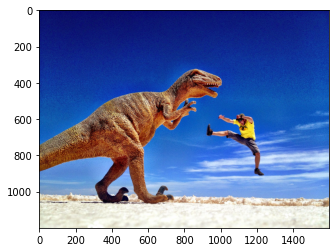

In [83]:
image_file_path = '/content/drive/MyDrive/subjective_img/sample5.jpg'
 

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
 

def load_image(image_file_path, transform=None):
    img = Image.open(image_file_path).convert('RGB')
    img = img.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        img = transform(img).unsqueeze(0)
    
    return img
 

# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])


# Load vocabulary wrapper
with open('/content/drive/MyDrive/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)


# Build models
encoder_model = CNNModel(512).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder_model = LSTMModel(512, 512, len(vocabulary), 1)
encoder_model = encoder_model.to(device)
decoder_model = decoder_model.to(device)


# Load the trained model parameters
encoder_model.load_state_dict(torch.load('/content/models_dir/encoder-10.ckpt'))
decoder_model.load_state_dict(torch.load('/content/models_dir/decoder-10.ckpt'))


# Prepare an image
img = load_image(image_file_path, transform)
img_tensor = img.to(device)


# Generate an caption from the image
feat = encoder_model(img_tensor)
sampled_indices = decoder_model.sample(feat)
sampled_indices = sampled_indices[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)


# Convert word_ids to words
predicted_caption = []
for token_index in sampled_indices:
    word = vocabulary.i2w[token_index]
    predicted_caption.append(word)
    if word == '<end>':
        break
predicted_sentence = ' '.join(predicted_caption)


# Print out the image and the generated caption
print (predicted_sentence)
img = Image.open(image_file_path)
plt.imshow(np.asarray(img))

to do:
1. Add LSTM module to it.

# checking number of parameters.

In [84]:
parameters = list(decoder_model.parameters()) + list(encoder_model.linear_layer.parameters()) + list(encoder_model.batch_norm.parameters())

for a in parameters:
  print(a.size())

torch.Size([4528, 512])
torch.Size([2048, 512])
torch.Size([2048, 512])
torch.Size([2048])
torch.Size([2048])
torch.Size([4528, 512])
torch.Size([4528])
torch.Size([512, 2048])
torch.Size([512])
torch.Size([512])
torch.Size([512])


# observations:
1. LSTM Layers = 2 BLEU score = 0.03775
2. LSTM Layers = 3 BLEU score = 0.02995
3. LSTM layers = 1 + hidden_layers = 1024 BLEU score = 0.065
4. LSTM layers = 1 + hidden_layers = 2048, input_layers=256 BLEU score = 0.06529080867767334
5. LSTM layers = 1 + hidden_layers = 512, input_layers = 512 BLEU score = 0.06791801005601883
